# TensorFlow Conditional WGAN-GP

Created by Paul Scott<br>
MSE Computer and Information Science<br>
University of Pennsylvania<br>

# References
* https://keras.io/examples/generative/wgan_gp/
* https://keras.io/examples/generative/conditional_gan/
* https://www.tensorflow.org/tutorials/generative/dcgan

# Imports

In [ ]:
%pip install clean-fid

import os
import glob
import time
import shutil
import imageio

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from cleanfid import fid
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, optimizers

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
noise_dim, num_classes = 0, 0

# Helper Functions

In [2]:
def generate_noise(count, class_index=None):
  noise = tf.random.normal((count, noise_dim))
  if class_index:
    noise_classes = tf.one_hot([class_index] * count, num_classes)
  else:
    noise_classes = tf.one_hot(np.random.randint(0, num_classes, size=count), num_classes)
  noise_classes = tf.reshape(noise_classes, (-1, num_classes))
  noise_with_classes = tf.concat((noise, noise_classes), axis=1)
  return noise_with_classes

def display_image_grid(images, num_examples):
  fig = plt.figure(figsize=(12, 12))
  for i in range(num_examples):
    grid_size = int(np.ceil(np.sqrt(num_examples)))
    fig.add_subplot(grid_size, grid_size, i + 1)
    plt.imshow(images[i] * 0.5 + 0.5)
    plt.axis('off')

def make_dir(directory):
  if not os.path.isdir(directory):
    os.makedirs(directory)

def remove_dir(directory):
  if os.path.isdir(directory):
    shutil.rmtree(directory)

# Load Dataset

In [3]:
dataset_name = 'greek_coins_sorted'
dataset_dir = f'input_images/{dataset_name}'

batch_size = 16
img_dim = 128
channels = 3
img_shape = (img_dim, img_dim, channels)

datagen = preprocessing.image.ImageDataGenerator(
  preprocessing_function=lambda x: (x - 127.5) / 127.5,
)

dataset = datagen.flow_from_directory(
  dataset_dir,
  target_size=(img_dim, img_dim),
  batch_size=batch_size,
)

num_classes = len(dataset.class_indices.keys())
img_shape_with_class = (img_dim, img_dim, channels + num_classes)

Found 42703 images belonging to 10 classes.


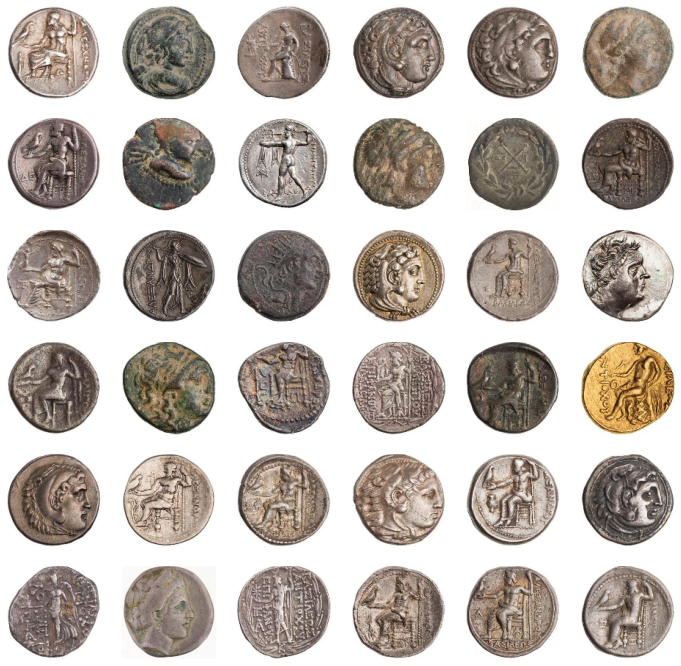

In [4]:
num_examples = 36

images = []
while len(images) < num_examples:
  images += list(dataset.next()[0])

display_image_grid(images, num_examples)

# Create WGAN-GP

Create generator

In [6]:
noise_dim = 512

def generator_block(filters, first_layer):
  filters = min(filters, 512)
  if first_layer:
    block_layers = [layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=4, use_bias=False)]
  else:
    block_layers = [
      layers.UpSampling2D(),
      layers.Conv2D(filters=filters, kernel_size=3, padding='same', use_bias=False),
    ]
  block_layers += [
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(filters=filters, kernel_size=3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
  ]
  return block_layers

filters = 2 ** (np.log2(img_dim) + 2)
min_filters = 16
first_layer = True
generator_layers = [layers.Reshape(target_shape=(1, 1, noise_dim + num_classes), input_shape=(noise_dim + num_classes,))]
while filters >= min_filters:
  generator_layers += generator_block(filters, first_layer)
  first_layer = False
  filters //= 2
generator_layers.append(layers.Conv2D(filters=3, kernel_size=1, padding='same', use_bias=False, activation='tanh'))

generator = models.Sequential(generator_layers)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 522)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4, 4, 512)        4276224   
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 512)         2359296   
                                                                 
 batch_normalization_13 (Bat  (None, 4, 4, 512)       

Create critic (similar to discriminator in DCGANs)

In [7]:
def critic_block(filters, last_layer):
  filters = min(filters, 512)
  block_layers = [
    layers.Conv2D(filters=filters, kernel_size=3, padding='same', use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Conv2D(
      filters=min(filters*2, 512) if not last_layer else noise_dim,
      kernel_size=3 if not last_layer else 4,
      strides=1 if not last_layer else 4,
      padding='same' if not last_layer else 'valid',
      use_bias=False,
    ),
    layers.LeakyReLU(0.2),
  ]
  if not last_layer:
    block_layers.append(layers.MaxPool2D())
  return block_layers

filters = 16
max_filters = 2 ** (np.log2(img_dim) + 2)
critic_layers = [
 layers.Conv2D(filters=16, kernel_size=1, padding='same', use_bias=False, input_shape=img_shape_with_class),
 layers.LeakyReLU(0.2), 
]
while filters <= max_filters:
  critic_layers += critic_block(filters, filters == max_filters)
  first_layer = False
  filters *= 2
critic_layers += [
  layers.Flatten(),
  layers.Dense(1),
]

critic = models.Sequential(critic_layers)
critic.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 16)      208       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 16)      2304      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 32)      4608      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)      

# Training

Wasserstein Gradient Penalty Loss (Critic and Generator Losses)

$L_C=\mathbb{E}[C(G(z))]-\mathbb{E}[C(x)]+\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$

$L_G=-\mathbb{E}[C(G(z))]$

Where

* $C$ is the critic

* $G$ is the generator

* $x$ is sampled from the distribution of real images

* $z$ is random noise such that $z\sim\mathcal{N}(0,1)$

* $i$ is an interpolation between real and fake images defined as $i=\alpha x-(1-\alpha)G(z)$ where $\alpha\sim\mathcal{U}(0,1)$

* $C(x)$ is the critic's score for an input real image $x$

* $G(z)$ is an image generated using noise $z$

* $C(G(z))$ is the critic's score for an input fake image $G(z)$

* $\lambda$ is the penalty amount hyperparameter (the code uses $\lambda=10$)

Loss Explanations

* The critic is trying to minimize $L_C$, which is equivalent to maximizing $\mathbb{E}[C(x)]$ and minimizing $\mathbb{E}[C(G(z))]$. The critic is trying to give the real images higher scores than the fake images.

* The generator is trying to minimize $L_G$, which is equivalent to maximizing $\mathbb{E}[C(G(z))]$. The generator is trying to trick the critic into giving fake images high scores.

* A penalty $\lambda\mathbb{E}[(||\nabla C(i)||_2-1)^2]$ is added to the critic loss to prevent the gradient of the critic from growing too large.

In [8]:
num_examples = 36

if not fid.test_stats_exists(dataset_name, 'clean'):
  fid.make_custom_stats(dataset_name, dataset_dir)

generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
critic_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
generator_losses, critic_losses, fid_scores = [], [], []
seed = generate_noise(num_examples)

checkpoint_dir = f'checkpoints/{dataset_name}'
output_dir = f'output_images/{dataset_name}'
losses_dir = f'losses/{dataset_name}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimizer,
  critic_optimizer=critic_optimizer,
  generator=generator,
  critic=critic,
)

def train(dataset, epochs, restore_epoch=0, save_freq=20, fid_freq=20):
  make_dir('seeds')
  np.save(f'seeds/{dataset_name}_seed.npy', seed)

  avg_time_per_epoch = 0
  for epoch in range(restore_epoch, epochs):
    start = time.time()
    should_save = (epoch + 1) % save_freq == 0
    should_calc_fid = (epoch + 1) % fid_freq == 0

    for _ in range(len(dataset)):
      image_batch, labels_batch = dataset.next()
      critic_loss = train_critic(image_batch, labels_batch)
      generator_loss = train_generator(labels_batch)

    generator_losses.append(generator_loss)
    critic_losses.append(critic_loss)

    make_dir(losses_dir)

    if epoch == 0 or should_calc_fid:
      fid = calculate_fid_score()
      fid_scores.append(fid)
      np.save(f'{losses_dir}/fid_scores.npy', fid_scores)
    elif epoch == restore_epoch:
      fid = calculate_fid_score()

    np.save(f'{losses_dir}/generator_losses.npy', generator_losses)
    np.save(f'{losses_dir}/critic_losses.npy', critic_losses)

    display.clear_output(wait=True)
    generate_and_save_images(epoch + 1)
    print(f'Generator Loss: {round(float(generator_loss), 3)} | Critic Loss: {round(float(critic_loss), 3)} | FID: {round(fid, 3)}')

    if should_save:
      checkpoint.save(file_prefix = checkpoint_prefix)

    avg_time_per_epoch = print_time(start, epoch, epochs, restore_epoch, avg_time_per_epoch)


def train_critic(real_images, real_labels):
  noise = tf.random.normal([len(real_images), noise_dim]) # z
  noise = tf.concat((noise, real_labels), axis=1) # add class labels to noise
  with tf.GradientTape() as critic_tape:
    fake_images = generator(noise, training=True) # G(z)
    
    real_images = add_labels_to_images(real_images, real_labels)
    fake_images = add_labels_to_images(fake_images, real_labels)

    real_output = critic(real_images, training=True) # C(x)
    fake_output = critic(fake_images, training=True) # C(G(z))
    
    critic_loss_unpenalized = calculate_critic_loss(real_output, fake_output) # E[C(G(z))] - E[C(x)]
    penalty = calculate_gradient_penalty(real_images, fake_images) # E[(||∇C(i)||₂ - 1)²]
    critic_loss = critic_loss_unpenalized + 10.0 * penalty # E[C(G(z))] - E[C(x)] + λ * E[(||∇C(i)||₂ - 1)²]

  gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
  critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
  return critic_loss


def train_generator(real_labels):
  noise = tf.random.normal([len(real_labels), noise_dim]) # z
  noise = tf.concat((noise, real_labels), axis=1) # add class labels to noise
  with tf.GradientTape() as generator_tape:
    fake_images = generator(noise, training=True) # G(z)
    fake_images = add_labels_to_images(fake_images, real_labels)
    fake_output = critic(fake_images, training=True) # C(G(z))
    generator_loss = calculate_generator_loss(fake_output) # -E[C(G(z))]

  gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  return generator_loss


# E[C(G(z))] - E[C(x)]
def calculate_critic_loss(real_output, fake_output):
  return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)


# -E[C(G(z))]
def calculate_generator_loss(fake_output):
  return -tf.reduce_mean(fake_output)


# E[(||∇C(i)||₂ - 1)²]
def calculate_gradient_penalty(real_images, fake_images):
  alpha = tf.random.normal((len(real_images), 1, 1, 1))
  interpolated = alpha * real_images + (1 - alpha) * fake_images # i = α * x + (1 - α) * G(z)

  with tf.GradientTape() as penalty_tape:
    penalty_tape.watch(interpolated)
    interpolated_output = critic(interpolated, training=True)

  grads = penalty_tape.gradient(interpolated_output, [interpolated])[0] # ∇C(i)
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3))) # ||∇C(i)||₂
  penalty = tf.reduce_mean((norm - 1.0) ** 2) # E[(||∇C(i)||₂ - 1)²]
  return penalty


def calculate_fid_score():
  remove_dir('fid_images')
  make_dir('fid_images')
  max_images = min(10000, len(dataset) * batch_size)
  for batch_num in range(len(dataset)):
    noise = generate_noise(batch_size)
    generated = generator.predict(noise)
    for i, image in enumerate(generated):
      print(f'Generated Images For FID: {batch_num * batch_size + i + 1}/{max_images}', end='\r')
      image = Image.fromarray((image * 127.5 + 127.5).astype(np.uint8))
      image.save(f'fid_images/{batch_num * batch_size + i}.png')
      if batch_num * batch_size + i + 1 == max_images:
        break
    else:
      continue
    break
  return fid.compute_fid('fid_images', dataset_name=dataset_name, dataset_split='custom')


def add_labels_to_images(images, labels):
  labels = tf.repeat(labels, (img_dim * img_dim), axis=1)
  labels = tf.reshape(labels, (-1, img_dim, img_dim, num_classes))
  return tf.concat((images, labels), axis=3)


def generate_and_save_images(epoch):
  make_dir(output_dir)
  predictions = generator(seed, training=False)
  display_image_grid(images=predictions, num_examples=num_examples)
  plt.savefig('{}/image_at_epoch_{:04d}.png'.format(output_dir, epoch))
  plt.show()


def print_time(epoch_start, epoch, total_epochs, restore_epoch, avg_time_per_epoch):
  time_for_epoch = time.time() - epoch_start
  epoch_adj = epoch - restore_epoch
  avg_time_per_epoch = (avg_time_per_epoch * epoch_adj + time_for_epoch) / (epoch_adj + 1)
  remaining_epochs = total_epochs - (epoch + 1)
  
  time_for_epoch_string = get_time_string(time_for_epoch)
  remaining_time_string = get_time_string(remaining_epochs * avg_time_per_epoch)

  print(f'Time For Epoch {epoch + 1}: {time_for_epoch_string}')
  print(f'Remaining Time: {remaining_time_string}')

  return avg_time_per_epoch


def get_time_string(total_seconds):
  hours = int(total_seconds // 3600)
  remainder = total_seconds % 3600
  minutes = int(remainder // 60)
  seconds = round(remainder % 60, 2)
  time_string = ''
  if hours > 0:
    time_string += f'{hours}h '
  if remainder >= 60:
    time_string += f'{minutes}m '
  time_string += f'{seconds}s'
  return time_string

Restore if necessary

In [26]:
checkpoint_num = 7

save_freq = 20
fid_freq = 20

seed = np.load(f'seeds/{dataset_name}_seed.npy')
generator_losses = list(np.load(f'{losses_dir}/generator_losses.npy'))
critic_losses = list(np.load(f'{losses_dir}/critic_losses.npy'))
fid_scores = list(np.load(f'{losses_dir}/fid_scores.npy'))

if checkpoint_num:
  generator_losses = generator_losses[:checkpoint_num * save_freq]
  critic_losses = critic_losses[:checkpoint_num * save_freq]
  fid_scores = fid_scores[:(checkpoint_num * save_freq) // fid_freq + 1]
  with open(f'{checkpoint_dir}/checkpoint', 'w') as ckpt:
    ckpt.write(
      f'''
      model_checkpoint_path: "ckpt-{checkpoint_num}"
      all_model_checkpoint_paths: "ckpt-{checkpoint_num}"
      '''
    )

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Train WGAN-GP

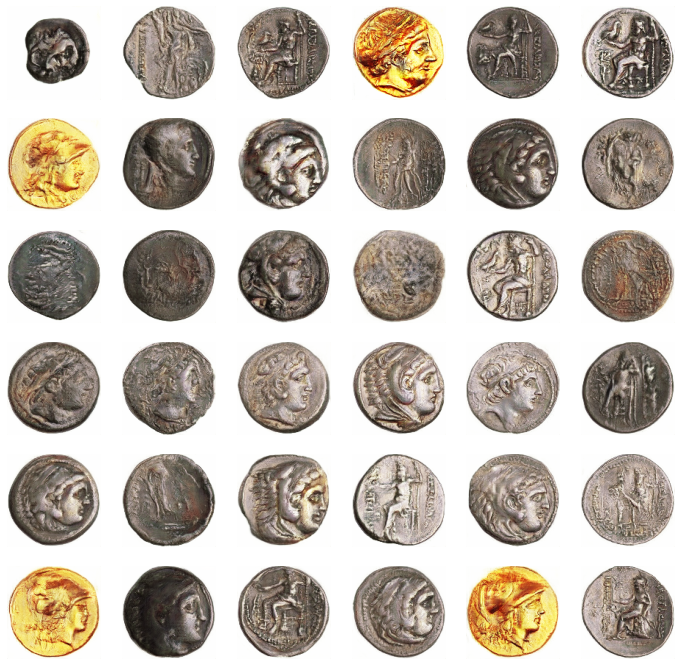

Generator Loss: -20.159 | Critic Loss: -4.995 | FID: 68.15
Time For Epoch 200: 14m 5.96s
Remaining Time: 0.0s


In [12]:
train(dataset, 200, 120)

Prepare plot data

In [22]:
def get_poly_curve(y_values):
  x = np.arange(len(y_values))
  y = np.array(y_values)
  curve = np.polyfit(x, y, 2)
  poly_y = np.sum([a * x ** (2 - i) for i, a in enumerate(curve)], axis=0)
  return x, poly_y

generator_curve_x, generator_curve_y = get_poly_curve(generator_losses)
critic_curve_x, critic_curve_y = get_poly_curve(critic_losses)

Plot losses

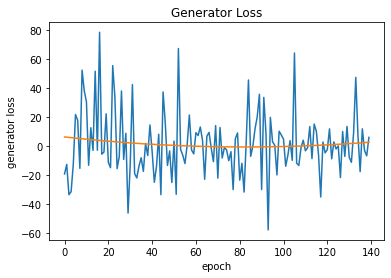

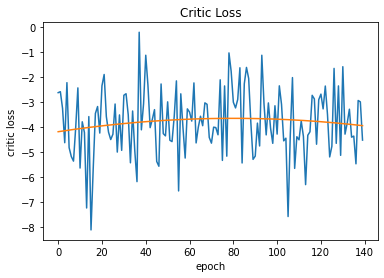

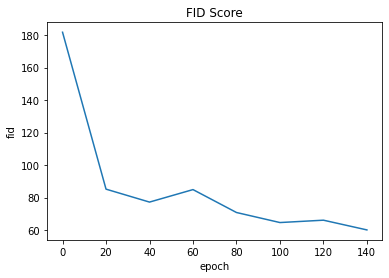

In [27]:
# plot generator loss
plt.plot(generator_losses)
plt.plot(generator_curve_x, generator_curve_y)
plt.title('Generator Loss')
plt.xlabel('epoch')
plt.ylabel('generator loss')
plt.show()

# plot critic loss
plt.plot(critic_losses)
plt.plot(critic_curve_x, critic_curve_y)
plt.title('Critic Loss')
plt.xlabel('epoch')
plt.ylabel('critic loss')
plt.show()

# plot fid scores
plt.plot(np.arange(0, len(fid_scores) * 20, 20), fid_scores)
plt.title('FID Score')
plt.xlabel('epoch')
plt.ylabel('fid')
plt.show()

Save generator

In [54]:
make_dir('saved_generators/')
models.save_model(generator, f'saved_generators/{dataset_name}')

2022-03-23 11:32:50.468172: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_generators/greek_coins_sorted/assets


Turn training progress images into gif

In [ ]:
skip_size = 5

with imageio.get_writer(f'gifs/{dataset_name}.gif', mode='I') as writer:
  filenames = sorted(glob.glob(f'output_images/{dataset_name}/image*.png'))
  for i in range(0, len(filenames), skip_size):
    writer.append_data(imageio.imread(filenames[i]))

# Results

Load generator

In [55]:
generator = models.load_model(f'saved_generators/{dataset_name}')

Generate images

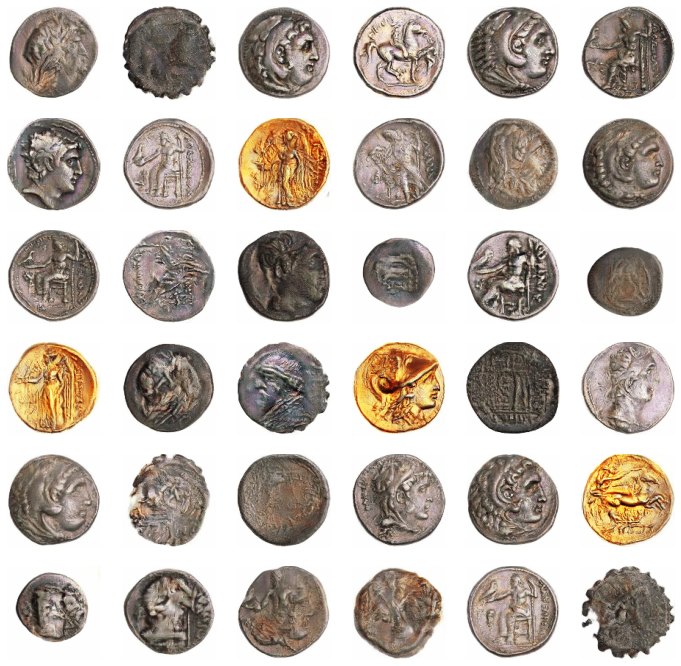

In [58]:
num_examples = 36
class_index = None

generated = generator(generate_noise(num_examples, class_index))
display_image_grid(generated, num_examples)

Explore latent space

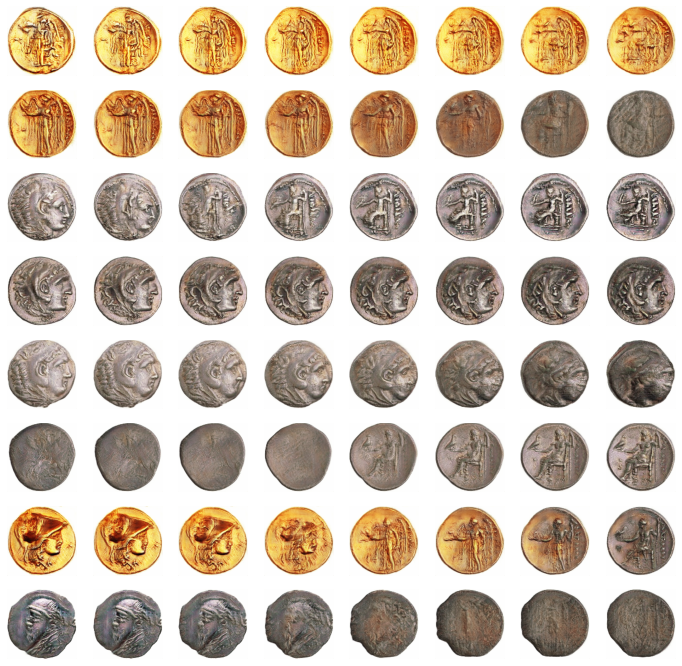

In [40]:
num_transitions = 7
num_examples = 8

fig = plt.figure(figsize=(12, 12))
for i in range(num_examples):
  classes = np.random.choice(np.arange(num_classes), size=2)
  start_noise = np.concatenate((np.random.normal(size=noise_dim), tf.one_hot(classes[0], num_classes))).reshape((1, noise_dim + num_classes))
  end_noise = np.concatenate((np.random.normal(size=noise_dim), tf.one_hot(classes[1], num_classes))).reshape((1, noise_dim + num_classes))
  for t in range(num_transitions + 1):
    step = t / (num_transitions + 1)
    noise = (1 - step) * start_noise + step * end_noise
    output = generator.predict(noise).reshape(img_shape)
    grid_size = int(np.ceil(np.sqrt(num_examples)))
    fig.add_subplot(num_transitions + 1, num_examples, i * (num_transitions + 1) + t + 1)
    plt.imshow(output * 0.5 + 0.5)
    plt.axis('off')